In [2]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask.array as da

In [4]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_EXHEAT_04A_TMAXJJA_Warming_2015-2044.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (mid - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\Ben\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


Difference in average tasmax (F, conversion first) saved to VCP_EXHEAT_04A_TMAXJJA_Warming_2015-2044.nc


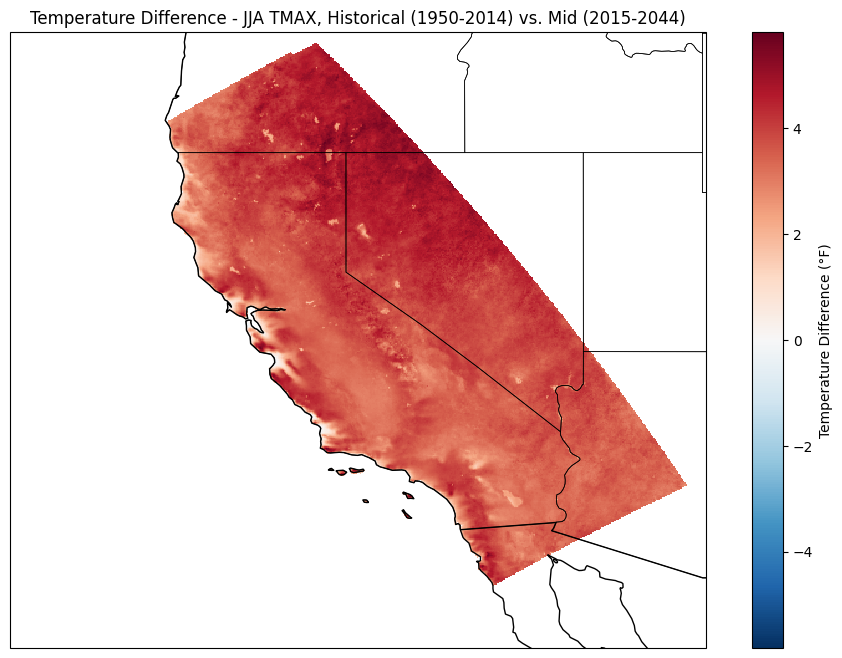

In [6]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Difference - JJA TMAX, Historical (1950-2014) vs. Mid (2015-2044)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_04A_TMAXJJA_Warming_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)

In [8]:
def calculate_tasmax_difference_f_first_dask(hist_file, mid_file, output_file="VCP_EXHEAT_04B_TMAXJJA_Warming_2045-2074.nc"):
    """
    Calculates the difference in average tasmax between two NetCDF files (hist.nc and mid.nc)
    after converting tasmax to Fahrenheit first, using dask for lazy evaluation.

    Args:
        hist_file (str): Path to the hist.nc file.
        mid_file (str): Path to the mid.nc file.
        output_file (str): Path to save the resulting NetCDF file.
    """
    try:
        hist_ds = xr.open_dataset(hist_file, chunks={'time': 'auto'}) #enable chunking
        mid_ds = xr.open_dataset(mid_file, chunks={'time': 'auto'}) #enable chunking

        # Select June, July, and August
        jja_mask = hist_ds['time.month'].isin([6, 7, 8])
        hist_ds = hist_ds.sel(time=jja_mask)
        jja_mask = mid_ds['time.month'].isin([6, 7, 8])
        mid_ds = mid_ds.sel(time=jja_mask)
        
        hist_tasmax = hist_ds["tasmax"]
        mid_tasmax = mid_ds["tasmax"]

        # Convert Kelvin to Fahrenheit: (K - 273.15) * 9/5 + 32
        hist_tasmax_f = (hist_tasmax - 273.15) * 9/5 + 32
        mid_tasmax_f = (mid_tasmax - 273.15) * 9/5 + 32

        # Calculate the average tasmax in Fahrenheit over the time dimension
        hist_avg_f = hist_tasmax_f.mean(dim="time")
        mid_avg_f = mid_tasmax_f.mean(dim="time")

        # Calculate the difference (mid - hist) in Fahrenheit
        diff_f = mid_avg_f - hist_avg_f

        # Create a new xarray DataArray with the Fahrenheit difference values
        diff_f_da = xr.DataArray(
            diff_f,
            coords=diff_f.coords,  # Copy coordinates from the original difference
            dims=diff_f.dims,
            attrs={"units": "degrees Fahrenheit", "description": "Difference in average tasmax (late - hist) in Fahrenheit (conversion first)"},
        )

        # Create a new Dataset and save it to a NetCDF file
        diff_ds = xr.Dataset({"tasmax": diff_f_da})
        diff_ds.to_netcdf(output_file)

        print(f"Difference in average tasmax (F, conversion first) saved to {output_file}")

    except FileNotFoundError:
        print("Error: One or both files not found.")
    except KeyError:
        print("Error: 'tasmax' variable not found in one or both files.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'hist_ds' in locals():
            hist_ds.close()
        if 'mid_ds' in locals():
            mid_ds.close()

# Example usage:
hist_file_path = "tasmax.ACCESS-CM2.historical.r1i1p1f1.1950-2014.LOCA2_CA_hybrid_v20230115.nc"  # Replace with the actual path
mid_file_path = "tasmax.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"    # Replace with the actual path

calculate_tasmax_difference_f_first_dask(hist_file_path, mid_file_path)

Difference in average tasmax (F, conversion first) saved to VCP_EXHEAT_04B_TMAXJJA_Warming_2045-2074.nc


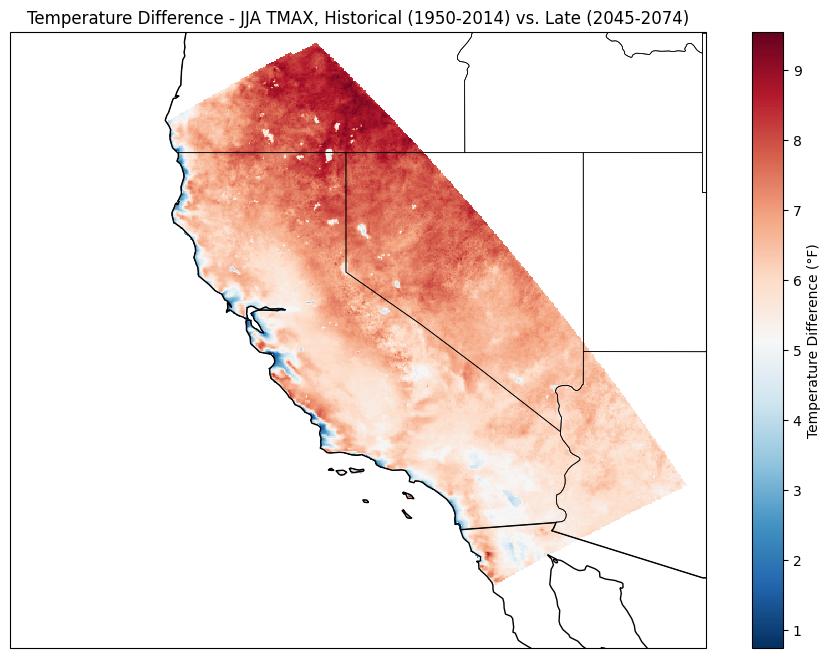

In [10]:
def map_tasmax_difference(netcdf_file, variable_name="tasmax", projection=ccrs.PlateCarree(), cmap='RdBu_r'):
    """
    Creates a map of the tasmax difference from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the tasmax difference.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax_diff_fahrenheit".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature Difference (°F)'})

        plt.title("Temperature Difference - JJA TMAX, Historical (1950-2014) vs. Late (2045-2074)")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_04B_TMAXJJA_Warming_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_tasmax_difference(netcdf_file_path)